## **Image Cleaning with Autoencoders**

### **Imports**

In [54]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

### **Load and Preprocess the [Dataset](https://drive.google.com/file/d/1_kg9xHF_E4-7smIWIrnPQGH0qBhwoGac/view?usp=sharing)**

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Unzipping noisy_documents.zip
!unzip -q /content/drive/MyDrive/noisy_documents.zip -d /content/data

(420, 540, 1)


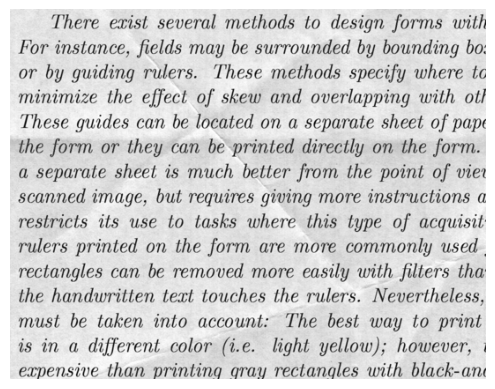

(258, 540, 1)


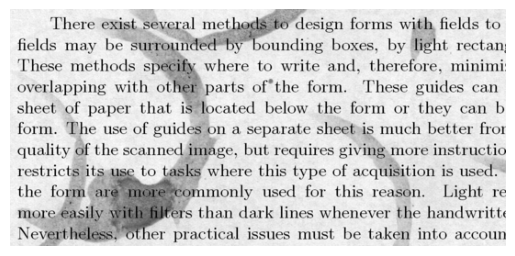

In [55]:
# View the size of the images
image=tf.io.read_file("/content/data/train_noise/149.png")
image=tf.image.decode_png(image, channels=1)
print(image.shape)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

image=tf.io.read_file("/content/data/train_noise/14.png")
image=tf.image.decode_png(image, channels=1)
print(image.shape)
plt.imshow(image, cmap="gray")
plt.axis("off");

**There are two different sizes, so all of them must be resized to have a uniform size. In this case, to the larger size**

In [56]:
batch_size=32
epochs=10
image_size=(420, 540)

In [57]:
def load_data(directory):
  dataset=tf.keras.utils.image_dataset_from_directory(
      directory=directory,
      labels=None,
      color_mode="grayscale",
      batch_size=32,
      image_size=image_size,
      shuffle=False,
      interpolation="bilinear"
  )
  return dataset

In [58]:
x_train=load_data("/content/data/train_noise")
y_train=load_data("/content/data/train_clean")
x_test=load_data("/content/data/test")

Found 144 files belonging to 1 classes.
Found 144 files belonging to 1 classes.
Found 72 files belonging to 1 classes.


In [59]:
for x_im, y_im, x_im_test in zip(x_train.take(1), y_train.take(1), x_test.take(1)):
  print(x_im.shape, y_im.shape, x_im_test.shape)

(32, 420, 540, 1) (32, 420, 540, 1) (32, 420, 540, 1)


In [60]:
x_im.numpy().min(), x_im.numpy().max()

(0.0, 255.0)

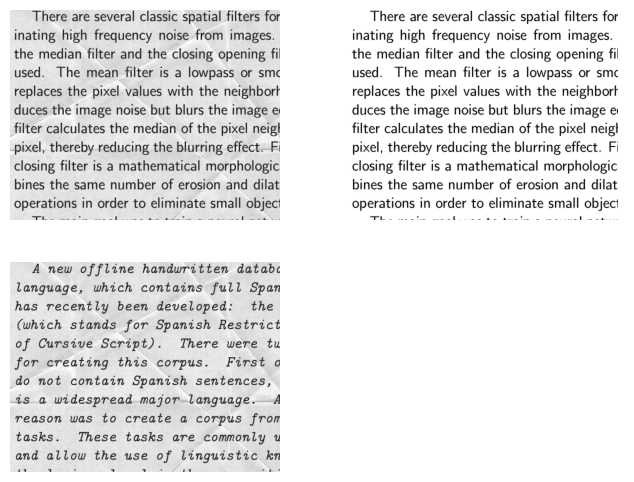

In [61]:
# Visualizing images from the datasets
id=10
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].imshow(x_im[id], cmap="gray")
ax[0, 0].axis("off")
ax[0, 1].imshow(y_im[id], cmap="gray")
ax[0, 1].axis("off")
ax[1, 0].imshow(x_im_test[id], cmap="gray")
ax[1, 0].axis("off")
ax[1, 1].axis("off");

In [62]:
def preprocessing(image):
  return tf.cast(image, dtype=tf.float32)/255

In [63]:
x_train=x_train.map(preprocessing)
y_train=y_train.map(preprocessing)
x_test=x_test.map(preprocessing)

In [64]:
train_dataset=tf.data.Dataset.zip((x_train, y_train)).shuffle(buffer_size=64, seed=123)

In [65]:
tf.keras.backend.clear_session()

### **Bulding Model**

In [66]:
# Autoencoder

input=tf.keras.Input(shape=(420, 540, 1))
encoder=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same")(input)
encoder=tf.keras.layers.MaxPooling2D(pool_size=(2,2))(encoder)
encoder=tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same")(encoder)
encoder=tf.keras.layers.MaxPooling2D(pool_size=(2,2))(encoder)

bottleneck=tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding="same")(encoder)
encoder=tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation="sigmoid", padding="same")(bottleneck)

decoder=tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same")(bottleneck)
decoder=tf.keras.layers.UpSampling2D(size=(2,2))(decoder)
decoder=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same")(decoder)
decoder=tf.keras.layers.UpSampling2D(size=(2,2))(decoder)
decoder=tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation="sigmoid", padding="same")(decoder)

encoder_model=tf.keras.Model(inputs=input, outputs=encoder, name="encoder")
autoencoder=tf.keras.Model(inputs=input, outputs=decoder, name="autoencoder")

In [67]:
encoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 210, 270, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 210, 270, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 105, 135, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 105, 135, 256)     2951

In [68]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 210, 270, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 210, 270, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 105, 135, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 105, 135, 256)     

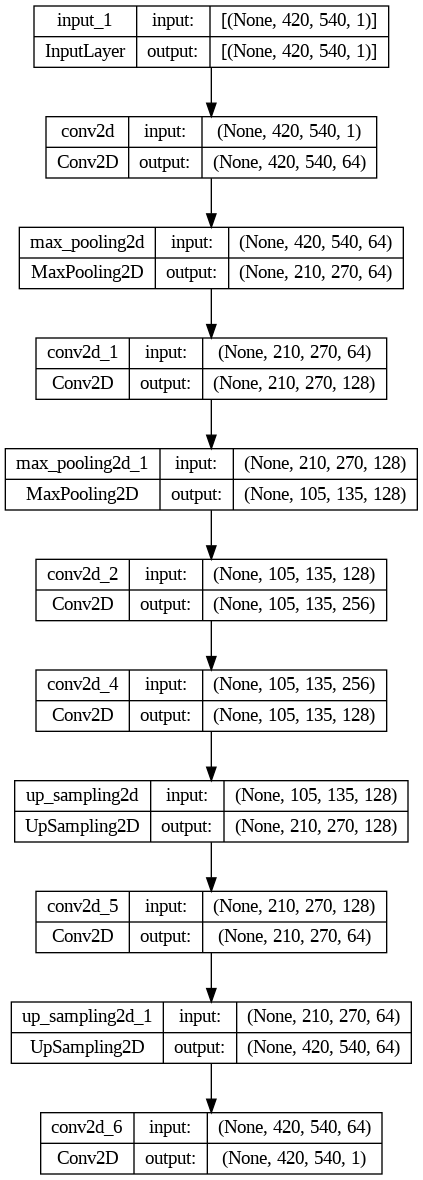

In [69]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True, show_layer_names=True, expand_nested=True)

### **Training Model**

In [70]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [71]:
epochs=20

In [72]:
tf.random.set_seed(123)

history=autoencoder.fit(train_dataset, epochs=epochs, verbose=1)

Epoch 1/20
5/5 [==============================] - 6s 739ms/step - loss: 0.4922
Epoch 2/20
5/5 [==============================] - 5s 733ms/step - loss: 0.3691
Epoch 3/20
5/5 [==============================] - 4s 733ms/step - loss: 0.3550
Epoch 4/20
5/5 [==============================] - 5s 736ms/step - loss: 0.3404
Epoch 5/20
5/5 [==============================] - 4s 840ms/step - loss: 0.3166
Epoch 6/20
5/5 [==============================] - 5s 746ms/step - loss: 0.2829
Epoch 7/20
5/5 [==============================] - 5s 742ms/step - loss: 0.2597
Epoch 8/20
5/5 [==============================] - 5s 744ms/step - loss: 0.2558
Epoch 9/20
5/5 [==============================] - 4s 746ms/step - loss: 0.2445
Epoch 10/20
5/5 [==============================] - 5s 747ms/step - loss: 0.2338
Epoch 11/20
5/5 [==============================] - 4s 751ms/step - loss: 0.2259
Epoch 12/20
5/5 [==============================] - 4s 748ms/step - loss: 0.2211
Epoch 13/20
5/5 [==============================] 

In [73]:
# Function display

def display_images(images, images_pred, encoders_pred, num_blocks=1, random=False):
  num_cols=3
  len_data=len(images)
  num_images=num_blocks*num_cols

  if random:
    indexes=np.random.choice(len_data, size=num_images)
  else:
    indexes=np.arange(num_images)

  for j in range(num_blocks):
    fig, ax = plt.subplots(3, num_cols, figsize=(12, 8))

    for i in range(num_cols):
      image=images[indexes[i+num_cols*j]]
      image_pred=images_pred[indexes[i+num_cols*j]]
      encoder=encoders_pred[indexes[i+num_cols*j]]

      ax[0,i].imshow(image, cmap="gray")
      ax[0,i].axis("off")
      ax[1,i].imshow(encoder, cmap="gray")
      ax[1,i].axis("off")
      ax[2,i].imshow(image_pred, cmap="gray")
      ax[2,i].axis("off")

    plt.show()
    print("*"*155)

### **Predictions**

In [74]:
x_train=x_train.unbatch().as_numpy_iterator()
x_train=np.array(list(x_train))

x_train.shape

(144, 420, 540, 1)

In [75]:
x_test=x_test.unbatch().as_numpy_iterator()
x_test=np.array(list(x_test))

x_test.shape

(72, 420, 540, 1)

In [76]:
y_train_pred = autoencoder.predict(x_train)
y_train_pred_enc = encoder_model.predict(x_train)

y_test_pred = autoencoder.predict(x_test)
y_test_pred_enc = encoder_model.predict(x_test)

3/3 [==============================] - 0s 108ms/step


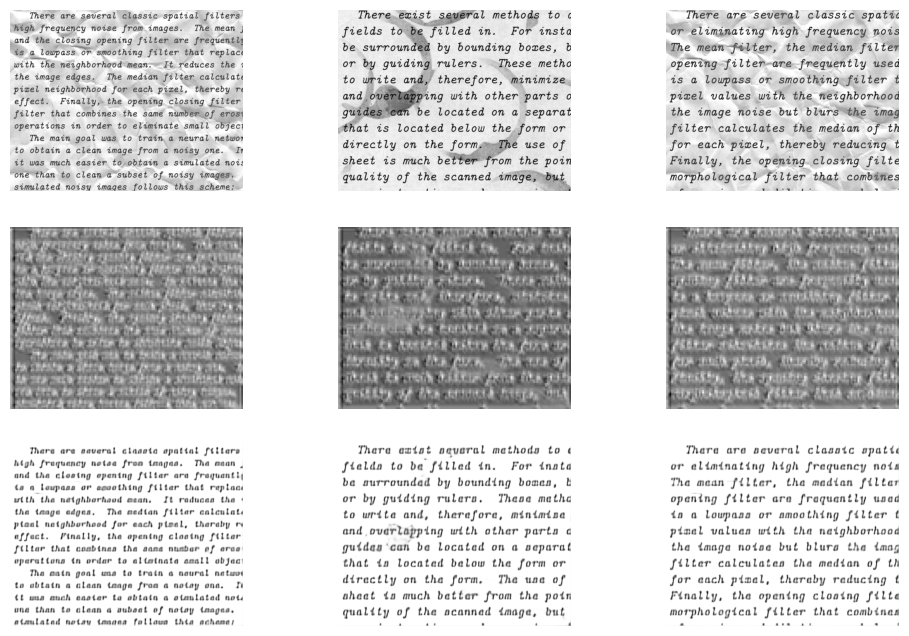

***********************************************************************************************************************************************************


In [77]:
# Training Set
display_images(x_train, y_train_pred, y_train_pred_enc, random=True)

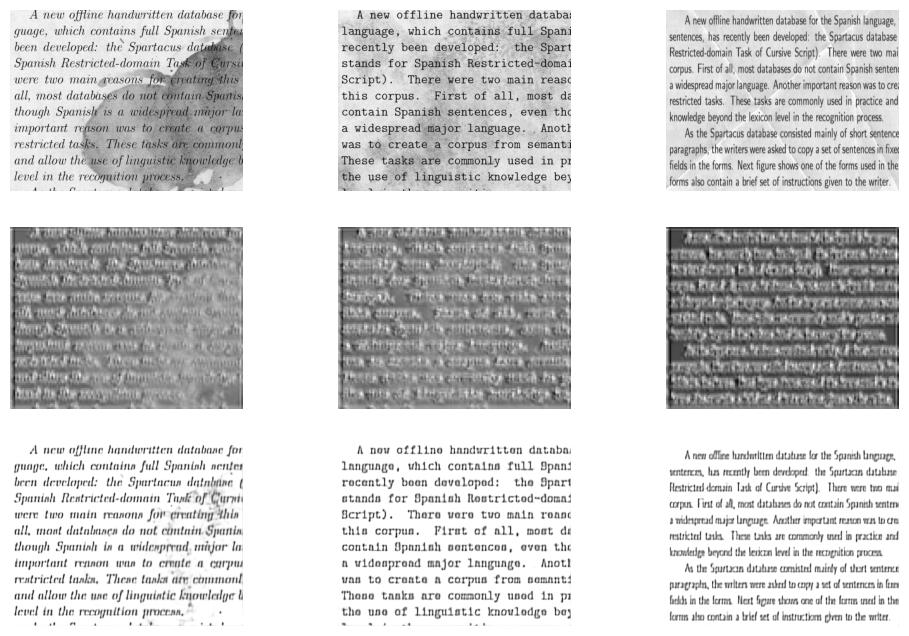

***********************************************************************************************************************************************************


In [79]:
# Testing Set
display_images(x_test, y_test_pred, y_test_pred_enc, random=True)